# Problem Statement 

### Context 
When deciding what courses to take, the typical Harvard student looks first to the Q-Guide, a compilation of the wisdom of Harvard students not too yonder. It contains both descriptive facts about classes — such as class enrollment size, favorability rating of professors, and average weekly workload — as well as normative judgments by students in the form of open-response comments on the course. 

### Course of Action 
Through exploratory data analysis and model generation, we aim understand how these comments and ratings affect students' decisions to enroll in classes.

We also plan to investigate other questions of interest such as: How do departments differ in terms of average course sentiment? Do smaller concentrations lessen undesirable factors to boost enrollment? How do comments and grading styles differ between required vs elective courses?

### Goal 
 Our goal is to identify the most significant predictors for a student to enroll in the course based on data provided by the Q-Guide. From there, we will be able to predict degrees of course enrollment in a course based on its previous years ratings. 


# Step 0: Importing Libraries 

In [101]:
# Import libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# GPT
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

In [ ]:
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# GPT
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

# Step 1: Data Reading

In [39]:
# Load the datasets
df = pd.read_csv("data/data.csv", index_col = 0)
df.head()

C:\Users\AndrewsMatthewHaines\AppData\Local\Temp\ipykernel_21580\2013055878.py:2: DtypeWarning: Columns (56,58) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/data.csv", index_col = 0)


,web-scraper-order,web-scraper-start-url,course,comments,year,term,course_title,course_number1,department1,course_number2,department2,name_key1,instructor_first_name,instructor_last_name,enrollment,responses,number_of_comments,Course_Overall_Rating,Course_Materials_Rating,Course_Assignments_Rating,Course_Feedback_Rating,Course_Section_Rating,Course_Workload_Rating,Course_Goals_Rating,Course_Recommend_Rating,...,Course_Recommend_Respondents,Course_Money_Respondents,Instructor_Return_Respondents,Instructor_Feedback_Respondents,Instructor_Participation_Respondents,Instructor_Enthusiasm_Respondents,Instructor_Accessible_Respondents,Instructor_Lectures_Respondents,Instructor_Overall_Respondents,Course_Overall_Distribution,Course_Materials_Distribution,Course_Assignments_Distribution,Course_Feedback_Distribution,Course_Section_Distribution,Course_Workload_Distribution,Course_Goals_Distribution,Course_Recommend_Distribution,Course_Money_Distribution,Instructor_Return_Distribution,Instructor_Feedback_Distribution,Instructor_Participation_Distribution,Instructor_Enthusiasm_Distribution,Instructor_Accessible_Distribution,Instructor_Lectures_Distribution,Instructor_Overall_Distribution
0,1522891683-18234,https://course-evaluation-reports.fas.harvard.edu/fas/list?yearterm=2006_1,AFRAMER 112: Black Humor: Performance Art and Literature,[],2006,fall,Black Humor: Performance Art and Literature,112,AFRAMER,NaN,NaN,AFRAMER 112,"""","""",45,21,0,4.1,4.4,3.8,3.6,4.0,3.0,NaN,4.2,...,21.0,NaN,7.0,9.0,19.0,20.0,20.0,20.0,20.0,"[1, 3, 0, 6, 11]","[0, 1, 2, 5, 13]","[1, 3, 1, 9, 6]","[2, 4, 2, 5, 8]","[1, 1, 3, 8, 7]","[9, 11, 1, 0, 0]",NaN,"[3, 1, 0, 2, 15]",NaN,"[0, 1, 2, 2, 15]","[0, 1, 2, 7, 10]","[0, 0, 1, 3, 16]","[0, 0, 3, 1, 16]","[0, 0, 2, 3, 14]","[1, 0, 1, 4, 3]","[0, 0, 1, 3, 3]"
1,1522891674-18223,https://course-evaluation-reports.fas.harvard.edu/fas/list?yearterm=2006_1,"AFRAMER 113: Fictions of Race, Facts of Racism: Perspectives from South African and African Ame...",[],2006,fall,"Fictions of Race, Facts of Racism: Perspectives from South African and African American Drama an...",113,AFRAMER,NaN,NaN,AFRAMER 113,NaN,NaN,0,[],0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1522891670-18217,https://course-evaluation-reports.fas.harvard.edu/fas/list?yearterm=2006_1,AFRAMER 116: Autobiography and Literary Imagination,[],2006,fall,Autobiography and Literary Imagination,116,AFRAMER,NaN,NaN,AFRAMER 116,"""","""",9,5,0,4.5,4.2,3.8,3.2,3.8,10.0,NaN,4.8,...,4.0,NaN,3.0,3.0,4.0,4.0,4.0,4.0,4.0,"[0, 0, 0, 2, 2]","[0, 0, 0, 3, 1]","[0, 1, 1, 0, 2]","[1, 1, 0, 0, 2]","[1, 0, 0, 1, 2]","[0, 0, 2, 2, 0]",NaN,"[0, 0, 0, 1, 3]",NaN,"[0, 0, 0, 2, 2]","[0, 1, 0, 1, 2]","[0, 0, 1, 2, 1]","[0, 0, 0, 1, 3]","[0, 1, 0, 0, 3]","[0, 1, 0, 0, 2]","[0, 1, 0, 0, 2]"
3,1522891657-18200,https://course-evaluation-reports.fas.harvard.edu/fas/list?yearterm=2006_1,AFRAMER 175: Introduction to African Music,[],2006,fall,Introduction to African Music,175,AFRAMER,NaN,NaN,AFRAMER 175,"""","""",14,13,0,4.4,4.1,3.7,4.0,4.0,5.0,NaN,4.7,...,13.0,NaN,10.0,12.0,10.0,13.0,9.0,12.0,13.0,"[0, 1, 2, 1, 9]","[0, 1, 1, 7, 4]","[0, 1, 4, 6, 2]","[0, 1, 3, 4, 5]","[0, 0, 0, 1, 0]","[2, 7, 4, 0, 0]",NaN,"[0, 0, 0, 4, 9]",NaN,"[0, 0, 1, 3, 9]","[0, 0, 2, 3, 7]","[0, 1, 5, 1, 2]","[0, 0, 1, 4, 8]","[0, 1, 0, 3, 6]","[0, 2, 2, 6, 2]","[0, 1, 3, 4, 2]"
4,1522891495-18013,https://course-evaluation-reports.fas.harvard.edu/fas/list?yearterm=2006_1,"AFRAMER 190: African-American Families: Politics, Culture, Experience",[],2006,fall,"African-American Families: Politics, Culture, Experience",190,AFRAMER,NaN,NaN,AFRAMER 190,"""","""",13,8,0,4.4,4.4,4.1,4.1,0.0,3.0,NaN,4.4,...,7.0,NaN,6.0,6.0,7.0,7.0,6.0,7.0,7.0,"[0, 0, 1, 2, 4]","[0, 0, 0, 4, 3]","[0, 1, 0, 3, 3]","[0, 1, 0, 3, 3]",[],"[2, 5, 0, 0, 0]",NaN,"[0, 0, 1, 2, 4]",NaN,"[0, 0, 1, 2, 4]","[0, 0, 1, 4, 2]","[0, 1, 1, 0, 4]","[0, 0, 1, 3, 3]","[0, 0, 1,

# Step 2 Creating New Course Categories 
The following code is used to create both general and specific course categories to make more meaningful insights into the data. 

For general categories, courses are divided into 'Arts & Humanities', 'STEM', 'Social Sciences', 'Expository', 'General Education', and 'First-Year' departments. For specific categories, these general ones are broken down further into more specific sub-types. 

### Create general class categories

In [40]:
df_copy = df.copy()

course_department_map = {
    'AFRIKAAN': 'arts_humanities',
    'AKKAD': 'arts_humanities',
    'AM-CIV': 'arts_humanities',
    'AMHARIC': 'arts_humanities',
    'AMSTDIES': 'arts_humanities',
    'AM_CIV': 'arts_humanities',
    'ANE': 'arts_humanities',
    'ARABIC': 'arts_humanities',
    'ARAMAIC': 'arts_humanities',
    'ARMEN': 'arts_humanities',
    'ARMENST': 'arts_humanities',
    'BCS': 'arts_humanities',
    'CAMEROON': 'arts_humanities',
    'CATALAN': 'arts_humanities',
    'CELTIC': 'arts_humanities',
    'CHAG': 'arts_humanities',
    'CHNSE': 'arts_humanities',
    'CHNSHIS': 'arts_humanities',
    'CHNSLING': 'arts_humanities',
    'CHNSLIT': 'arts_humanities',
    'CL': 'arts_humanities',
    'CLASARCH': 'arts_humanities',
    'CLASSIC': 'arts_humanities',
    'CLAS-HEB': 'arts_humanities',
    'CLASPHIL': 'arts_humanities',
    'CLS-STDY': 'arts_humanities',
    'COMPLIT': 'arts_humanities',
    'CZCH': 'arts_humanities',
    'DRAMA': 'arts_humanities',
    'DUTCH': 'arts_humanities',
    'EABS': 'arts_humanities',
    'EAFM': 'arts_humanities',
    'EGYPTIAN': 'arts_humanities',
    'EASTD': 'arts_humanities',
    'ENGLISH': 'arts_humanities',
    'FOLKMYTH': 'arts_humanities',
    'FOR-CULT': 'arts_humanities',
    'FRENCH': 'arts_humanities',
    'GERMAN': 'arts_humanities',
    'GERMPHIL': 'arts_humanities',
    'GERM-STD': 'arts_humanities',
    'GIKUYU': 'arts_humanities',
    'GREEK': 'arts_humanities',
    'GULLAH': 'arts_humanities',
    'HAA': 'arts_humanities',
    'HAITIAN': 'arts_humanities',
    'HAUSA': 'arts_humanities',
    'HEBREW': 'arts_humanities',
    'HIND-URD': 'arts_humanities',
    'HINDI': 'arts_humanities',
    'HIS-STD': 'arts_humanities',
    'HIST': 'arts_humanities',
    'HIST-LIT': 'arts_humanities',
    'HUMAN': 'arts_humanities',
    'HUMFRAME': 'arts_humanities',
    'HUMQSTNS': 'arts_humanities',
    'IGBO': 'arts_humanities',
    'INDN-ST': 'arts_humanities',
    'IRANCIV': 'arts_humanities',
    'IRANIAN': 'arts_humanities',
    'IRISH': 'arts_humanities',
    'ISLAMCIV': 'arts_humanities',
    'ITAL': 'arts_humanities',
    'JAMAICAN': 'arts_humanities',
    'JAPAN': 'arts_humanities',
    'JAPNHIST': 'arts_humanities',
    'JAPNLIT': 'arts_humanities',
    'JEWISHST': 'arts_humanities',
    'KINYARWA': 'arts_humanities',
    'KOREAN': 'arts_humanities',
    'KORHIST': 'arts_humanities',
    'KORLIT': 'arts_humanities',
    'LATIN': 'arts_humanities',
    'LAT-STD': 'arts_humanities',
    'LING': 'arts_humanities',
    'LINGALA': 'arts_humanities',
    'LIT': 'arts_humanities',
    'LIT-ART': 'arts_humanities',
    'LITER': 'arts_humanities',
    'LITERTRE': 'arts_humanities',
    'MALAGASI': 'arts_humanities',
    'MANCHU': 'arts_humanities',
    'MEDGREEK': 'arts_humanities',
    'MEDLATIN': 'arts_humanities',
    'MEDVLSTD': 'arts_humanities',
    'MES': 'arts_humanities',
    'MOD-HEB': 'arts_humanities',
    'MODGRK': 'arts_humanities',
    'MODMDEST': 'arts_humanities',
    'MONGOLN': 'arts_humanities',
    'MUSIC': 'arts_humanities',
    'NEC': 'arts_humanities',
    'NEP': 'arts_humanities',
    'NEPALI': 'arts_humanities',
    'NKO': 'arts_humanities',
    'NORWGN': 'arts_humanities',
    'PAL': 'arts_humanities',
    'PALI': 'arts_humanities',
    'PERSIAN': 'arts_humanities',
    'PHIL': 'arts_humanities',
    'PLSH': 'arts_humanities',
    'PORTUG': 'arts_humanities',
    'PULAAR': 'arts_humanities',
    'RELIGION': 'arts_humanities',
    'ROM-LANG': 'arts_humanities',
    'ROM-STD': 'arts_humanities',
    'RSRA': 'arts_humanities',
    'RUSS': 'arts_humanities',
    'SALLC': 'arts_humanities',
    'SANSKRIT': 'arts_humanities',
    'SANSKRT': 'arts_humanities',
    'SAS': 'arts_humanities',
    'SCAND': 'arts_humanities',
    'SCTGALIC': 'arts_humanities',
    'SEMPHIL': 'arts_humanities',
    'SHONA': 'arts_humanities',
    'SLAVIC': 'arts_humanities',
    'SOMALI': 'arts_humanities',
    'SPANSH': 'arts_humanities',
    'SUDANESE': 'arts_humanities',
    'SWAHILI': 'arts_humanities',
    'SWEDISH': 'arts_humanities',
    'TAM': 'arts_humanities',
    'TDM': 'arts_humanities',
    'THI': 'arts_humanities',
    'TIBET': 'arts_humanities',
    'TIBETAN': 'arts_humanities',
    'TIBHIST': 'arts_humanities',
    'TIGRINYA': 'arts_humanities',
    'TURKISH': 'arts_humanities',
    'TWI': 'arts_humanities',
    'UKRA': 'arts_humanities',
    'UKRAN': 'arts_humanities',
    'URD': 'arts_humanities',
    'URDU': 'arts_humanities',
    'UYGHUR': 'arts_humanities',
    'VES': 'arts_humanities',
    'VIETNAM': 'arts_humanities',
    'WELSH': 'arts_humanities',
    'WOLOF': 'arts_humanities',
    'WSTAFRCN': 'arts_humanities',
    'YIDDISH': 'arts_humanities',
    'YORUBA': 'arts_humanities',
    'ZULU': 'arts_humanities',

    'APCOMP': 'stem',
    'APMTH': 'stem',
    'APPHY': 'stem',
    'ASTRON': 'stem',
    'BBS': 'stem',
    'BCMP': 'stem',
    'BE': 'stem',
    'BIOCHSCI': 'stem',
    'BIOLOGY': 'stem',
    'BIOLSCI': 'stem',
    'BIOPHYS': 'stem',
    'BIOSTAT': 'stem',
    'BPH': 'stem',
    'BSDM': 'stem',
    'CELLBIO': 'stem',
    'CHEM': 'stem',
    'CHEMBIO': 'stem',
    'COMPSCI': 'stem',
    'CPB': 'stem',
    'DRB': 'stem',
    'E-PSCI': 'stem',
    'ENG-SCI': 'stem',
    'GENETIC': 'stem',
    'HBTM': 'stem',
    'HEB': 'stem',
    'IMMUN': 'stem',
    'IMUIL': 'stem',
    'LIFESCI': 'stem',
    'LPS': 'stem',
    'MATH': 'stem',
    'MBB': 'stem',
    'MCB': 'stem',
    'MED_SCI': 'stem',
    'MED-SCI': 'stem',
    'MICROBI': 'stem',
    'NEURO': 'stem',
    'NEUROBIO': 'stem',
    'OEB': 'stem',
    'PATHOL': 'stem',
    'PHS': 'stem',
    'PHYSCI': 'stem',
    'PHYSICS': 'stem',
    'SCIENCE': 'stem',
    'SCRB': 'stem',
    'SHBT': 'stem',
    'STAT': 'stem',
    'SYSBIO': 'stem',
    'SYSTBIO': 'stem',
    'VIROLOGY': 'stem',
    

    'AFRAMER': 'social_science',
    'ANTHRO': 'social_science',
    'BUSSTUD': 'social_science',
    'ECON': 'social_science',
    'ESPP': 'social_science',
    'EDC': 'social_science',
    'EMR': 'social_science',
    'GHHP': 'social_science',
    'GOV': 'social_science',
    'HISTSCI': 'social_science',
    'HLTHPOL': 'social_science',
    'HSEMR-CU': 'social_science',
    'HSEMR-EL': 'social_science',
    'HSEMR-LE': 'social_science',
    'HSEMR-LO': 'social_science',
    'HSEMR-MA': 'social_science',
    'HSEMR-PF': 'social_science',
    'HSEMR-WI': 'social_science',
    'PSY': 'social_science',
    'SOC-ANAL': 'social_science',
    'SOC-STD': 'social_science',
    'SOCIOL': 'social_science',
    'SPOL': 'social_science',
    'WOMGEN': 'social_science',
    'WOM-STD': 'social_science',

    'EXPOS': 'expository',

    'FRSEMR': 'first_year',

    'AESTHINT': 'general_education',
    'CULTBLF': 'general_education',
    'GEN-ED': 'general_education',
    'EMREAS': 'general_education',
    'ETHRSON': 'general_education',
    'MOR-REAS': 'general_education',
    'QNT-REAS': 'general_education',
    'SCILIVSY': 'general_education',
    'SCIPHUNV': 'general_education',
    'SOCWORLD': 'general_education',
    'US-WORLD': 'general_education',

    'UNKNOWN': 'misc'

    
}

df_copy["responses"] = pd.to_numeric(df_copy["responses"], errors='coerce', downcast='integer')
df_copy['division'] = np.vectorize(course_department_map.get)(df_copy['department1'])
df_copy['school_year'] = df_copy.apply(lambda row: str(row['year']) if row['term'] == 'Spring' else str(row['year'] - 1), axis=1)
df_copy['response_rate'] = df_copy['responses'] / df_copy['enrollment']

df_copy.head()

,web-scraper-order,web-scraper-start-url,course,comments,year,term,course_title,course_number1,department1,course_number2,department2,name_key1,instructor_first_name,instructor_last_name,enrollment,responses,number_of_comments,Course_Overall_Rating,Course_Materials_Rating,Course_Assignments_Rating,Course_Feedback_Rating,Course_Section_Rating,Course_Workload_Rating,Course_Goals_Rating,Course_Recommend_Rating,...,Instructor_Feedback_Respondents,Instructor_Participation_Respondents,Instructor_Enthusiasm_Respondents,Instructor_Accessible_Respondents,Instructor_Lectures_Respondents,Instructor_Overall_Respondents,Course_Overall_Distribution,Course_Materials_Distribution,Course_Assignments_Distribution,Course_Feedback_Distribution,Course_Section_Distribution,Course_Workload_Distribution,Course_Goals_Distribution,Course_Recommend_Distribution,Course_Money_Distribution,Instructor_Return_Distribution,Instructor_Feedback_Distribution,Instructor_Participation_Distribution,Instructor_Enthusiasm_Distribution,Instructor_Accessible_Distribution,Instructor_Lectures_Distribution,Instructor_Overall_Distribution,division,school_year,response_rate
0,1522891683-18234,https://course-evaluation-reports.fas.harvard.edu/fas/list?yearterm=2006_1,AFRAMER 112: Black Humor: Performance Art and Literature,[],2006,fall,Black Humor: Performance Art and Literature,112,AFRAMER,NaN,NaN,AFRAMER 112,"""","""",45,21.0,0,4.1,4.4,3.8,3.6,4.0,3.0,NaN,4.2,...,9.0,19.0,20.0,20.0,20.0,20.0,"[1, 3, 0, 6, 11]","[0, 1, 2, 5, 13]","[1, 3, 1, 9, 6]","[2, 4, 2, 5, 8]","[1, 1, 3, 8, 7]","[9, 11, 1, 0, 0]",NaN,"[3, 1, 0, 2, 15]",NaN,"[0, 1, 2, 2, 15]","[0, 1, 2, 7, 10]","[0, 0, 1, 3, 16]","[0, 0, 3, 1, 16]","[0, 0, 2, 3, 14]","[1, 0, 1, 4, 3]","[0, 0, 1, 3, 3]",social_science,2005,0.467
1,1522891674-18223,https://course-evaluation-reports.fas.harvard.edu/fas/list?yearterm=2006_1,"AFRAMER 113: Fictions of Race, Facts of Racism: Perspectives from South African and African Ame...",[],2006,fall,"Fictions of Race, Facts of Racism: Perspectives from South African and African American Drama an...",113,AFRAMER,NaN,NaN,AFRAMER 113,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,social_science,2005,NaN
2,1522891670-18217,https://course-evaluation-reports.fas.harvard.edu/fas/list?yearterm=2006_1,AFRAMER 116: Autobiography and Literary Imagination,[],2006,fall,Autobiography and Literary Imagination,116,AFRAMER,NaN,NaN,AFRAMER 116,"""","""",9,5.0,0,4.5,4.2,3.8,3.2,3.8,10.0,NaN,4.8,...,3.0,4.0,4.0,4.0,4.0,4.0,"[0, 0, 0, 2, 2]","[0, 0, 0, 3, 1]","[0, 1, 1, 0, 2]","[1, 1, 0, 0, 2]","[1, 0, 0, 1, 2]","[0, 0, 2, 2, 0]",NaN,"[0, 0, 0, 1, 3]",NaN,"[0, 0, 0, 2, 2]","[0, 1, 0, 1, 2]","[0, 0, 1, 2, 1]","[0, 0, 0, 1, 3]","[0, 1, 0, 0, 3]","[0, 1, 0, 0, 2]","[0, 1, 0, 0, 2]",social_science,2005,0.556
3,1522891657-18200,https://course-evaluation-reports.fas.harvard.edu/fas/list?yearterm=2006_1,AFRAMER 175: Introduction to African Music,[],2006,fall,Introduction to African Music,175,AFRAMER,NaN,NaN,AFRAMER 175,"""","""",14,13.0,0,4.4,4.1,3.7,4.0,4.0,5.0,NaN,4.7,...,12.0,10.0,13.0,9.0,12.0,13.0,"[0, 1, 2, 1, 9]","[0, 1, 1, 7, 4]","[0, 1, 4, 6, 2]","[0, 1, 3, 4, 5]","[0, 0, 0, 1, 0]","[2, 7, 4, 0, 0]",NaN,"[0, 0, 0, 4, 9]",NaN,"[0, 0, 1, 3, 9]","[0, 0, 2, 3, 7]","[0, 1, 5, 1, 2]","[0, 0, 1, 4, 8]","[0, 1, 0, 3, 6]","[0, 2, 2, 6, 2]","[0, 1, 3, 4, 2]",social_science,2005,0.929
4,1522891495-18013,https://course-evaluation-reports.fas.harvard.edu/fas/list?yearterm=2006_1,"AFRAMER 190: African-American Families: Politics, Culture, Experience",[],2006,fall,"African-American Families: Politics, Culture, Experience",190,AFRAMER,NaN,NaN,AFRAMER 190,"""","""",13,8.0,0,4.4,4.4,4.1,4.1,0.0,3.0,NaN,4.4,...,6.0,7.0,7.0,6.0,7.0,7.0,"[0, 0, 1, 2, 4]","[0, 0, 0, 4, 3]","[0, 1, 0, 3, 3]","[0, 1, 0, 3, 3]",[],"[2, 5, 0, 0, 0]",NaN,"[0, 0, 1, 2, 4]",NaN,"[0, 0, 1, 2, 4]","[0, 0, 1, 4, 2]","[0, 1, 1, 0, 4]","[0, 0, 1, 3, 3]","[0, 0, 1, 

### Create specific class categories 

In [41]:
spec_course_department_map = {
    'AFRIKAAN': 'languages',
    'AKKAD': 'languages',
    'AM-CIV': 'civ_studies',
    'AMHARIC': 'languages',
    'AMSTDIES': 'civ_studies',
    'ANE': 'regional_studies',
    'ARABIC': 'languages',
    'ARAMAIC': 'languages',
    'ARMEN': 'laguages',
    'ARMENST': 'regional_studies',
    'BCS': 'languages',
    'CAMEROON': 'languages',
    'CATALAN': 'languages',
    'CELTIC': 'regional_studies',
    'CHAG': 'languages',
    'CHNSE': 'languages',
    'CHNSHIS': 'history',
    'CHNSLING': 'linguistics',
    'CHNSLIT': 'literature',
    'CL': 'literature',
    'CLASARCH': 'literature',
    'CLASSIC': 'literature',
    'CLAS-HEB': 'languages',
    'CLASPHIL': 'philosophy',
    'CLS-STDY': 'literature',
    'COMPLIT': 'literature',
    'CZCH': 'languages',
    'DRAMA': 'performing_arts',
    'DUTCH': 'languages',
    'EABS': 'religion',
    'EAFM': 'visual_arts',
    'EGYPTIAN': 'languages',
    'EASTD': 'regional_studies',
    'ENGLISH': 'literature',
    'FOLKMYTH': 'literature',
    'FOR-CULT': 'literature',
    'FRENCH': 'languages',
    'GERMAN': 'languages',
    'GERMPHIL': 'philosophy',
    'GERM-STD': 'regional_studies',
    'GIKUYU': 'languages',
    'GREEK': 'languages',
    'GULLAH': 'languages',
    'HAA': 'visual_arts',
    'HAITIAN': 'languages',
    'HAUSA': 'languages',
    'HEBREW': 'languages',
    'HIND-URD': 'languages',
    'HINDI': 'languages',
    'HIS-STD': 'history',
    'HIST': 'history',
    'HIST-LIT': 'literature',
    'HUMAN': 'literature',
    'HUMFRAME': 'literature',
    'HUMQSTNS': 'literature',
    'IGBO': 'languages',
    'INDN-ST': 'regional_studies',
    'IRANCIV': 'civ_studies',
    'IRANIAN': 'languages',
    'IRISH': 'languages',
    'ISLAMCIV': 'civ_studies',
    'ITAL': 'languages',
    'JAMAICAN': 'languages',
    'JAPAN': 'languages',
    'JAPNHIST': 'history',
    'JAPNLIT': 'literature',
    'JEWISHST': 'history',
    'KINYARWA': 'languages',
    'KOREAN': 'languages',
    'KORHIST': 'history',
    'KORLIT': 'literature',
    'LATIN': 'languages',
    'LAT-STD': 'literature',
    'LING': 'linguistics',
    'LINGALA': 'linguistics',
    'LIT': 'literature',
    'LIT-ART': 'literature',
    'LITER': 'literature',
    'LITERTRE': 'literature',
    'MALAGASI': 'languages',
    'MANCHU': 'languages',
    'MEDGREEK': 'languages',
    'MEDLATIN': 'languages',
    'MEDVLSTD': 'social_studies',
    'MES': 'civ_studies',
    'MOD-HEB': 'languages',
    'MODGRK': 'languages',
    'MODMDEST': 'civ_studies',
    'MONGOLN': 'languages',
    'MUSIC': 'performing_arts',
    'NEC': 'performing_arts',
    'NEP': 'languages',
    'NEPALI': 'languages',
    'NKO': 'languages',
    'NORWGN': 'languages',
    'PAL': 'languages',
    'PALI': 'languages',
    'PERSIAN': 'languages',
    'PHIL': 'philosophy',
    'PLSH': 'languages',
    'PORTUG': 'languages',
    'PULAAR': 'languages',
    'RELIGION': 'religion',
    'ROM-LANG': 'languages',
    'ROM-STD': 'literature',
    'RSRA': 'regional_studies',
    'RUSS': 'languages',
    'SALLC': 'languages',
    'SANSKRIT': 'languages',
    'SANSKRT': 'languages',
    'SAS': 'regional_studies',
    'SCAND': 'languages',
    'SCTGALIC': 'languages',
    'SEMPHIL': 'languages',
    'SHONA': 'languages',
    'SLAVIC': 'languages',
    'SOMALI': 'languages',
    'SPANSH': 'languages',
    'SUDANESE': 'languages',
    'SWAHILI': 'languages',
    'SWEDISH': 'languages',
    'TAM': 'languages',
    'TDM': 'performing_arts',
    'THI': 'languages',
    'TIBET': 'languages',
    'TIBETAN': 'languages',
    'TIBHIST': 'history',
    'TIGRINYA': 'languages',
    'TURKISH': 'languages',
    'TWI': 'languages',
    'UKRA': 'languages',
    'UKRAN': 'languages',
    'URD': 'languages',
    'URDU': 'languages',
    'UYGHUR': 'languages',
    'VES': 'visual_arts',
    'VIETNAM': 'languages',
    'WELSH': 'languages',
    'WOLOF': 'languages',
    'WSTAFRCN': 'languages',
    'YIDDISH': 'languages',
    'YORUBA': 'languages',
    'ZULU': 'languages',

    'APCOMP': 'seas',
    'APMTH': 'seas',
    'APPHY': 'seas',
    'ASTRON': 'physical_sciences',
    'BBS': 'life_sciences',
    'BCMP': 'life_sciences',
    'BE': 'life_sciences',
    'BIOCHSCI': 'life_sciences',
    'BIOLOGY': 'life_sciences',
    'BIOLSCI': 'life_sciences',
    'BIOPHYS': 'life_sciences',
    'BIOSTAT': 'life_sciences',
    'BPH': 'life_sciences',
    'BSDM': 'life_sciences',
    'CELLBIO': 'life_sciences',
    'CHEM': 'physical_sciences',
    'CHEMBIO': 'life_sciences',
    'COMPSCI': 'seas',
    'CPB': 'life_sciences',
    'DRB': 'life_sciences',
    'E-PSCI': 'physical_sciences',
    'ENG-SCI': 'seas',
    'GENETIC': 'life_sciences',
    'HBTM': 'medical_sciences',
    'HEB': 'life_sciences',
    'IMMUN': 'medical_sciences',
    'IMUIL': 'medical_sciences',
    'LIFESCI': 'life_sciences',
    'LPS': 'life_sciences',
    'MATH': 'seas',
    'MBB': 'life_sciences',
    'MCB': 'life_sciences',
    'MED-SCI': 'medical_sciences',
    'MICROBI': 'life_sciences',
    'NEURO': 'life_sciences',
    'NEUROBIO': 'life_sciences',
    'OEB': 'life_sciences',
    'PATHOL': 'medical_sciences',
    'PHS': 'medical_sciences',
    'PHYSCI': 'physical_sciences',
    'PHYSICS': 'physical_sciences',
    'SCIENCE': 'physical_sciences',
    'SCRB': 'life_sciences',
    'SHBT': 'stem',
    'STAT': 'seas',
    'SYSBIO': 'medical_sciences',
    'SYSTBIO': 'medical_sciences',
    'VIROLOGY': 'medical_sciences',
    

    'AFRAMER': 'ethnic_studies',
    'ANTHRO': 'behavioral_science',
    'BUSSTUD': 'economics',
    'ECON': 'economics',
    'ESPP': 'politics',
    'EDC': 'behavioral_science',
    'EMR': 'ethnic_studies',
    'GHHP': 'politics',
    'GOV': 'politics',
    'HISTSCI': 'history',
    'HLTHPOL': 'politics',
    'HSEMR-CU': 'politics',
    'HSEMR-EL': 'politics',
    'HSEMR-LE': 'politics',
    'HSEMR-LO': 'politics',
    'HSEMR-MA': 'politics',
    'HSEMR-PF': 'politics',
    'HSEMR-WI': 'politics',
    'PSY': 'behavioral_science',
    'SOC-ANAL': 'behavioral_science',
    'SOC-STD': 'behavioral_science',
    'SOCIOL': 'behavioral_science',
    'SPOL': 'behavioral_science',
    'WOMGEN': 'gender_studies',
    'WOM-STD': 'gender_studies',

    'EXPOS': 'expository',

    'FRSEMR': 'first_year',

    'AESTHINT': 'general_education',
    'CULTBLF': 'general_education',
    'GEN-ED': 'general_education',
    'EMREAS': 'general_education',
    'ETHRSON': 'general_education',
    'MOR-REAS': 'general_education',
    'QNT-REAS': 'general_education',
    'SCILIVSY': 'general_education',
    'SCIPHUNV': 'general_education',
    'SOCWORLD': 'general_education',
    'US-WORLD': 'general_education',

    'UNKNOWN': 'misc'

    
}

df_copy["responses"] = pd.to_numeric(df_copy["responses"], errors='coerce', downcast='integer')

df_copy['spec_division'] = np.vectorize(spec_course_department_map.get)(df_copy['department1'])
df_copy['school_year'] = df_copy.apply(lambda row: str(row['year']) if row['term'] == 'Spring' else str(row['year'] - 1), axis=1)
df_copy['response_rate'] = df_copy['responses'] / df_copy['enrollment']


df_copy.head()

,web-scraper-order,web-scraper-start-url,course,comments,year,term,course_title,course_number1,department1,course_number2,department2,name_key1,instructor_first_name,instructor_last_name,enrollment,responses,number_of_comments,Course_Overall_Rating,Course_Materials_Rating,Course_Assignments_Rating,Course_Feedback_Rating,Course_Section_Rating,Course_Workload_Rating,Course_Goals_Rating,Course_Recommend_Rating,...,Instructor_Participation_Respondents,Instructor_Enthusiasm_Respondents,Instructor_Accessible_Respondents,Instructor_Lectures_Respondents,Instructor_Overall_Respondents,Course_Overall_Distribution,Course_Materials_Distribution,Course_Assignments_Distribution,Course_Feedback_Distribution,Course_Section_Distribution,Course_Workload_Distribution,Course_Goals_Distribution,Course_Recommend_Distribution,Course_Money_Distribution,Instructor_Return_Distribution,Instructor_Feedback_Distribution,Instructor_Participation_Distribution,Instructor_Enthusiasm_Distribution,Instructor_Accessible_Distribution,Instructor_Lectures_Distribution,Instructor_Overall_Distribution,division,school_year,response_rate,spec_division
0,1522891683-18234,https://course-evaluation-reports.fas.harvard.edu/fas/list?yearterm=2006_1,AFRAMER 112: Black Humor: Performance Art and Literature,[],2006,fall,Black Humor: Performance Art and Literature,112,AFRAMER,NaN,NaN,AFRAMER 112,"""","""",45,21.0,0,4.1,4.4,3.8,3.6,4.0,3.0,NaN,4.2,...,19.0,20.0,20.0,20.0,20.0,"[1, 3, 0, 6, 11]","[0, 1, 2, 5, 13]","[1, 3, 1, 9, 6]","[2, 4, 2, 5, 8]","[1, 1, 3, 8, 7]","[9, 11, 1, 0, 0]",NaN,"[3, 1, 0, 2, 15]",NaN,"[0, 1, 2, 2, 15]","[0, 1, 2, 7, 10]","[0, 0, 1, 3, 16]","[0, 0, 3, 1, 16]","[0, 0, 2, 3, 14]","[1, 0, 1, 4, 3]","[0, 0, 1, 3, 3]",social_science,2005,0.467,ethnic_studies
1,1522891674-18223,https://course-evaluation-reports.fas.harvard.edu/fas/list?yearterm=2006_1,"AFRAMER 113: Fictions of Race, Facts of Racism: Perspectives from South African and African Ame...",[],2006,fall,"Fictions of Race, Facts of Racism: Perspectives from South African and African American Drama an...",113,AFRAMER,NaN,NaN,AFRAMER 113,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,social_science,2005,NaN,ethnic_studies
2,1522891670-18217,https://course-evaluation-reports.fas.harvard.edu/fas/list?yearterm=2006_1,AFRAMER 116: Autobiography and Literary Imagination,[],2006,fall,Autobiography and Literary Imagination,116,AFRAMER,NaN,NaN,AFRAMER 116,"""","""",9,5.0,0,4.5,4.2,3.8,3.2,3.8,10.0,NaN,4.8,...,4.0,4.0,4.0,4.0,4.0,"[0, 0, 0, 2, 2]","[0, 0, 0, 3, 1]","[0, 1, 1, 0, 2]","[1, 1, 0, 0, 2]","[1, 0, 0, 1, 2]","[0, 0, 2, 2, 0]",NaN,"[0, 0, 0, 1, 3]",NaN,"[0, 0, 0, 2, 2]","[0, 1, 0, 1, 2]","[0, 0, 1, 2, 1]","[0, 0, 0, 1, 3]","[0, 1, 0, 0, 3]","[0, 1, 0, 0, 2]","[0, 1, 0, 0, 2]",social_science,2005,0.556,ethnic_studies
3,1522891657-18200,https://course-evaluation-reports.fas.harvard.edu/fas/list?yearterm=2006_1,AFRAMER 175: Introduction to African Music,[],2006,fall,Introduction to African Music,175,AFRAMER,NaN,NaN,AFRAMER 175,"""","""",14,13.0,0,4.4,4.1,3.7,4.0,4.0,5.0,NaN,4.7,...,10.0,13.0,9.0,12.0,13.0,"[0, 1, 2, 1, 9]","[0, 1, 1, 7, 4]","[0, 1, 4, 6, 2]","[0, 1, 3, 4, 5]","[0, 0, 0, 1, 0]","[2, 7, 4, 0, 0]",NaN,"[0, 0, 0, 4, 9]",NaN,"[0, 0, 1, 3, 9]","[0, 0, 2, 3, 7]","[0, 1, 5, 1, 2]","[0, 0, 1, 4, 8]","[0, 1, 0, 3, 6]","[0, 2, 2, 6, 2]","[0, 1, 3, 4, 2]",social_science,2005,0.929,ethnic_studies
4,1522891495-18013,https://course-evaluation-reports.fas.harvard.edu/fas/list?yearterm=2006_1,"AFRAMER 190: African-American Families: Politics, Culture, Experience",[],2006,fall,"African-American Families: Politics, Culture, Experience",190,AFRAMER,NaN,NaN,AFRAMER 190,"""","""",13,8.0,0,4.4,4.4,4.1,4.1,0.0,3.0,NaN,4.4,...,7.0,7.0,6.0,7.0,7.0,"[0, 0, 1, 2, 4]","[0, 0, 0, 4, 3]","[0, 1, 0, 3, 3]","[0, 1, 0, 3, 3]",[],"[2, 5, 0, 0, 0]",NaN,"[0, 0, 1, 2, 4]",NaN,"[0, 0, 1, 2, 4]","[0, 0, 1, 4, 2]","[0, 1, 1, 0, 4]","[0, 0, 

### Elective or not

In [42]:
# HELP

# Step 3: Identifiying and Cleaning Missing Data 
Look at the missing data and drop columns with more than 50% of the data missing. Includes summary statistics, and data shapes.

### Generating Missingness Percentage for Each Column

In [43]:
# Calculate the percentage of missing values for each column
missing_percentage = df_copy.isnull().mean() * 100

# Display the percentage of missing data by column
missing_percentage.sort_values(ascending=False)

Course_Goals_Distribution                99.996
Course_Goals_Respondents                 99.996
Course_Goals_Rating                      99.996
course_number2                           99.060
department2                              99.060
Course_Money_Distribution                91.721
Course_Money_Respondents                 91.718
Course_Money_Rating                      91.718
Instructor_Return_Distribution           34.960
Instructor_Return_Rating                 34.960
Instructor_Return_Respondents            34.960
Instructor_Enthusiasm_Distribution       33.097
Instructor_Enthusiasm_Respondents        33.097
Instructor_Enthusiasm_Rating             33.097
Instructor_Overall_Distribution          29.632
Instructor_Overall_Respondents           29.632
Instructor_Overall_Rating                29.632
Instructor_Participation_Respondents     29.622
Instructor_Accessible_Respondents        29.622
Instructor_Lectures_Respondents          29.622
Instructor_Lectures_Rating              

### Removing Columns with more than 50% Missingness

In [44]:
# Remove columns with more than 50% missing values
columns_to_drop = missing_percentage[missing_percentage > 50].index
data_cleaned = df_copy.drop(columns=columns_to_drop)
data_cleaned = data_cleaned.drop(columns = ['web-scraper-order','web-scraper-start-url'])

# Show the shape of the data before and after
original_shape = df.shape
cleaned_shape = data_cleaned.shape

original_shape, cleaned_shape, columns_to_drop.tolist()

((28398, 65),
 (28398, 59),
 ['course_number2',
  'department2',
  'Course_Goals_Rating',
  'Course_Money_Rating',
  'Course_Goals_Respondents',
  'Course_Money_Respondents',
  'Course_Goals_Distribution',
  'Course_Money_Distribution'])

In [45]:
data_cleaned.describe()

,year,enrollment,responses,number_of_comments,Course_Overall_Rating,Course_Materials_Rating,Course_Assignments_Rating,Course_Feedback_Rating,Course_Section_Rating,Course_Workload_Rating,Course_Recommend_Rating,Instructor_Return_Rating,Instructor_Feedback_Rating,Instructor_Participation_Rating,Instructor_Enthusiasm_Rating,Instructor_Accessible_Rating,Instructor_Lectures_Rating,Instructor_Overall_Rating,Course_Overall_Respondents,Course_Materials_Respondents,Course_Assignments_Respondents,Course_Feedback_Respondents,Course_Section_Respondents,Course_Workload_Respondents,Course_Recommend_Respondents,Instructor_Return_Respondents,Instructor_Feedback_Respondents,Instructor_Participation_Respondents,Instructor_Enthusiasm_Respondents,Instructor_Accessible_Respondents,Instructor_Lectures_Respondents,Instructor_Overall_Respondents,response_rate
count,28398.000,28398.000,25209.000,28398.000,25001.000,25001.000,25001.000,25001.000,25000.000,24896.000,25001.000,18470.000,19991.000,19986.000,18999.000,19986.000,19986.000,19983.000,25001.000,25001.000,25001.000,25001.000,25000.000,25001.000,25001.000,18470.000,19991.000,19986.000,18999.000,19986.000,19986.000,19983.000,25209.000
mean,2012.243,22.517,20.311,11.861,4.225,4.175,4.077,4.081,3.618,5.977,4.262,4.324,4.011,4.218,4.409,4.259,4.222,4.373,20.088,19.458,19.605,19.227,15.043,19.254,19.967,8.152,7.741,12.607,18.500,15.952,18.113,18.737,0.784
std,3.416,48.031,42.742,46.760,0.579,0.748,0.754,0.805,1.678,3.873,0.576,0.699,1.171,0.931,0.740,0.802,0.936,0.563,42.292,41.786,42.120,41.471,39.593,41.186,42.107,10.331,9.545,19.857,36.224,29.532,36.252,36.375,0.196
min,2006.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.028
25%,2009.000,6.000,5.000,0.000,3.900,3.900,3.800,3.700,3.400,4.000,4.000,4.000,3.800,4.000,4.200,4.000,4.000,4.000,5.000,5.000,5.000,5.000,1.000,5.000,5.000,3.000,3.000,4.000,5.000,5.000,4.000,5.000,0.667
50%,2012.000,11.000,9.000,0.000,4.300,4.300,4.200,4.200,4.200,5.400,4.300,4.500,4.300,4.400,4.600,4.400,4.500,4.500,9.000,9.000,9.000,9.000,3.000,9.000,9.000,6.000,6.000,7.000,9.000,8.000,8.000,9.000,0.833
75%,2015.000,19.000,17.000,8.000,4.700,4.600,4.500,4.600,4.800,7.200,4.700,4.900,4.800,4.800,4.900,4.800,4.800,4.800,17.000,16.000,16.000,16.000,11.000,16.000,17.000,10.000,10.000,13.000,16.000,15.000,16.000,16.000,0.929
max,2018.000,921.000,856.000,2246.000,5.000,5.000,5.000,5.000,5.000,96.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,849.000,848.000,848.000,848.000,733.000,851.000,847.000,202.000,191.000,597.000,707.000,594.000,712.000,713.000,2.750


# Step 4: Exploratory Data Analysis
Analyzing data and generating visualizations by focusing on trends across general departments. By doing so, this will inform our model pipeline later on. 

In [46]:
average_enrollment = data_cleaned.groupby('division')['enrollment'].mean().reset_index()
average_enrollment

,division,enrollment
0,arts_humanities,15.048
1,expository,26.489
2,first_year,9.311
3,general_education,72.102
4,misc,5.333
5,social_science,24.021
6,stem,29.155


### Visualizing Average Enrollment 

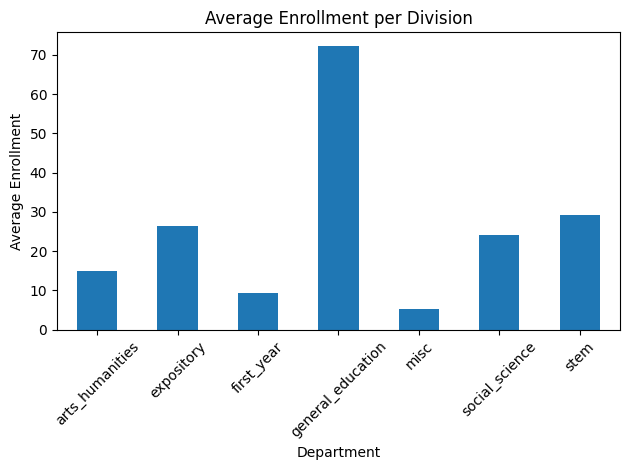

In [47]:
# Plot the average enrollment per department as a bar chart
average_enrollment.plot(kind='bar', x='division', y='enrollment', legend=False)

# Set the title and labels
plt.title('Average Enrollment per Division')
plt.xlabel('Department')
plt.ylabel('Average Enrollment')
plt.xticks(rotation=45)  # Rotate the x-axis labels to show them better

# Show the plot
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()

### Visualizing Total Enrollment 

Text(0, 0.5, 'Total Enrollment')

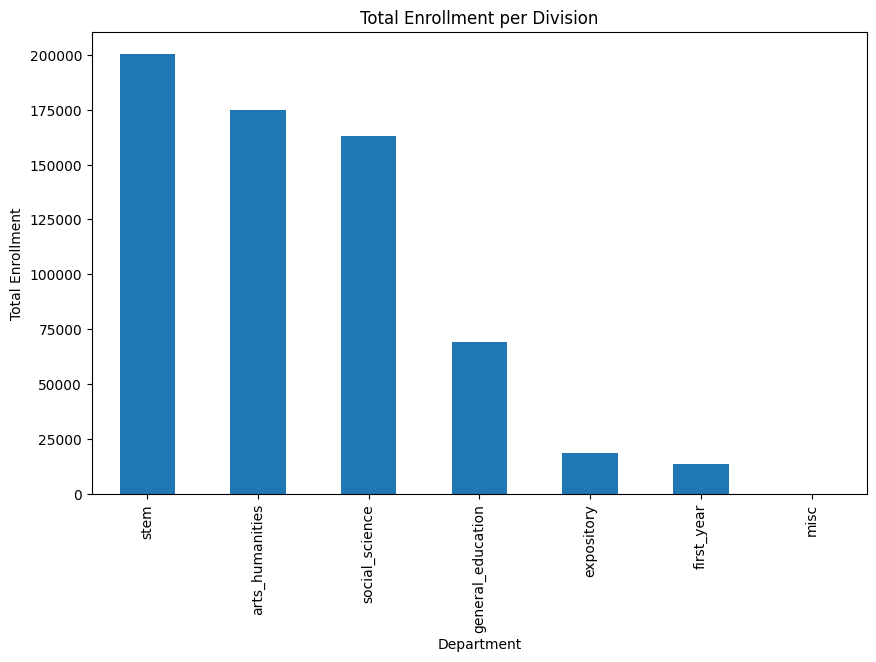

In [48]:
total_enrollment = data_cleaned.groupby('division')['enrollment'].sum().sort_values(ascending=False)

# Plotting the total enrollment per department as a bar chart
total_enrollment.plot(kind='bar', figsize=(10, 6))

# Adding title and labels
plt.title('Total Enrollment per Division')
plt.xlabel('Department')
plt.ylabel('Total Enrollment')

### Visualizing Total Enrollment over Time

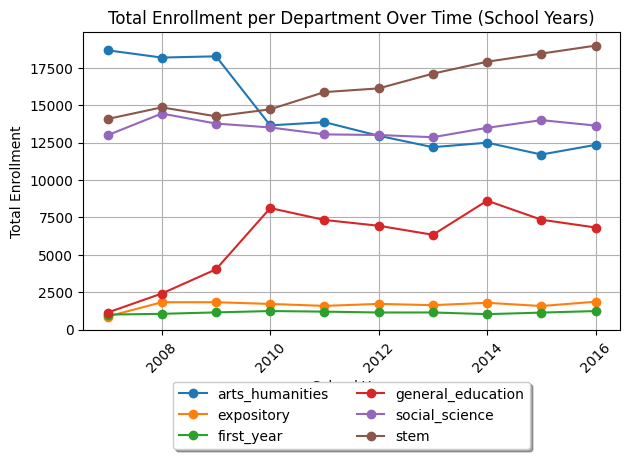

In [49]:
# Filter out 'misc' department and the years 2005 and 2017
filtered_df = data_cleaned[(data_cleaned['division'] != 'misc') & (data_cleaned['year'] > 2006) & (data_cleaned['year'] < 2017)]

# Group by department and school_year and sum enrollment
grouped_df_filtered = filtered_df.groupby(['division', 'year']).agg({'enrollment': 'sum'}).reset_index()

# Pivot the DataFrame for easier plotting
pivot_df_filtered = grouped_df_filtered.pivot(index='year', columns='division', values='enrollment')

# Plotting
pivot_df_filtered.plot(kind='line', marker='o')
plt.title('Total Enrollment per Department Over Time (School Years)')
plt.xlabel('School Year')
plt.ylabel('Total Enrollment')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
plt.tight_layout()
plt.show()

In [50]:
data_cleaned.loc[(data_cleaned['enrollment'] > 20) & 
            (data_cleaned['division'] == 'expository') & 
            (data_cleaned['year'].isin([2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020])), 'enrollment'] = 20

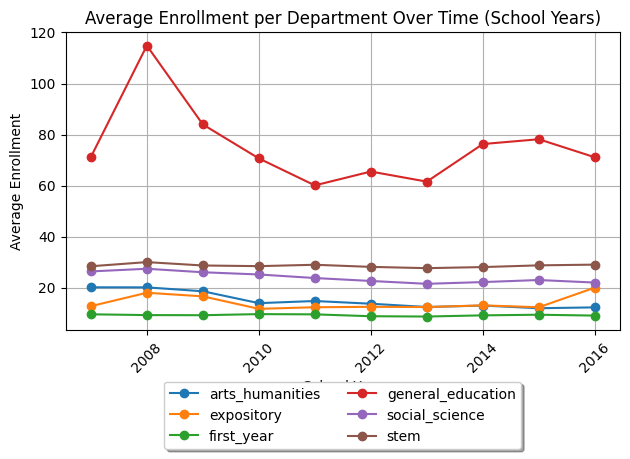

In [51]:
# Filter out 'misc' department and the years 2005 and 2017
filtered_df = data_cleaned[(data_cleaned['division'] != 'misc') & (data_cleaned['year'] > 2006) & (data_cleaned['year'] < 2017)]

# Group by department and school_year and sum enrollment
grouped_df_filtered = filtered_df.groupby(['division', 'year']).agg({'enrollment': 'mean'}).reset_index()

# Pivot the DataFrame for easier plotting
pivot_df_filtered = grouped_df_filtered.pivot(index='year', columns='division', values='enrollment')

# Plotting
pivot_df_filtered.plot(kind='line', marker='o')
plt.title('Average Enrollment per Department Over Time (School Years)')
plt.xlabel('School Year')
plt.ylabel('Average Enrollment')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
plt.tight_layout()
plt.show()

In [52]:
# Drop all classes with enrollment below 5 (outliers)

In [53]:
df_copy_drop5 = data_cleaned[(data_cleaned['enrollment'] > 5) & (data_cleaned['division'] != 'misc')]

### Visualizing Average Response Rate 

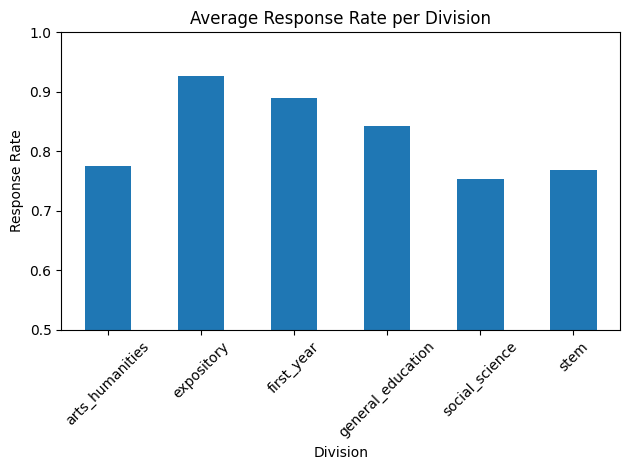

In [54]:
average_rr = df_copy_drop5.groupby('division')['response_rate'].mean().reset_index()

# Plot the average enrollment per department as a bar chart
average_rr.plot(kind='bar', x='division', y='response_rate', legend=False)

# Set the title and labels
plt.title('Average Response Rate per Division')
plt.xlabel('Division')
plt.ylabel('Response Rate')
plt.ylim(0.5, 1)
plt.xticks(rotation=45)  # Rotate the x-axis labels to show them better

# Show the plot
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()

### Visualizing Average Course Rating Variables 

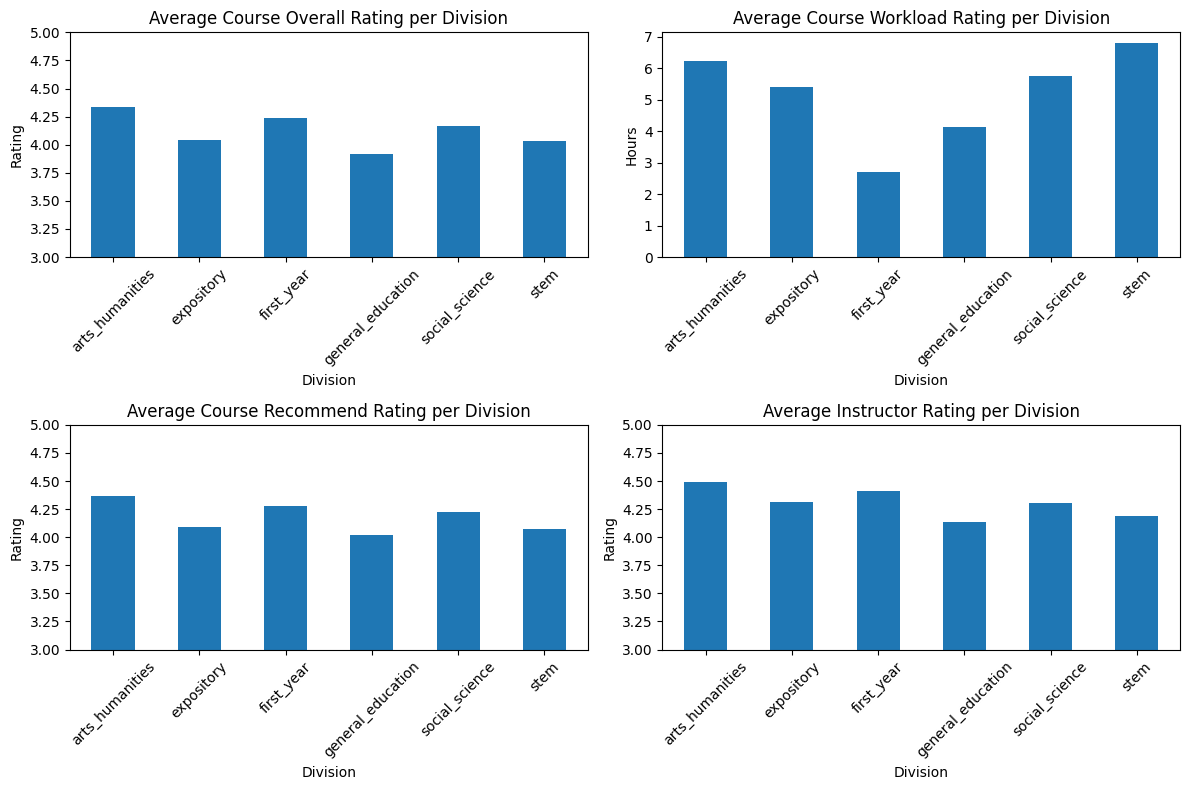

In [55]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# First plot
average_cor = df_copy_drop5.groupby('division')['Course_Overall_Rating'].mean().reset_index()
average_cor.plot(kind='bar', x='division', y='Course_Overall_Rating', legend=False, ax=axs[0, 0])
axs[0, 0].set_title('Average Course Overall Rating per Division')
axs[0, 0].set_xlabel('Division')
axs[0, 0].set_ylabel('Rating')
axs[0, 0].set_ylim(3, 5)
axs[0, 0].tick_params(axis='x', rotation=45)

# Second plot
average_cwr = df_copy_drop5.groupby('division')['Course_Workload_Rating'].mean().reset_index()
average_cwr.plot(kind='bar', x='division', y='Course_Workload_Rating', legend=False, ax=axs[0, 1])
axs[0, 1].set_title('Average Course Workload Rating per Division')
axs[0, 1].set_xlabel('Division')
axs[0, 1].set_ylabel('Hours')
axs[0, 1].tick_params(axis='x', rotation=45)

# Third plot
average_crr = df_copy_drop5.groupby('division')['Course_Recommend_Rating'].mean().reset_index()
average_crr.plot(kind='bar', x='division', y='Course_Recommend_Rating', legend=False, ax=axs[1, 0])
axs[1, 0].set_title('Average Course Recommend Rating per Division')
axs[1, 0].set_xlabel('Division')
axs[1, 0].set_ylabel('Rating')
axs[1, 0].set_ylim(3, 5)
axs[1, 0].tick_params(axis='x', rotation=45)

# Fourth plot
average_ior = df_copy_drop5.groupby('division')['Instructor_Overall_Rating'].mean().reset_index()
average_ior.plot(kind='bar', x='division', y='Instructor_Overall_Rating', legend=False, ax=axs[1, 1])
axs[1, 1].set_title('Average Instructor Rating per Division')
axs[1, 1].set_xlabel('Division')
axs[1, 1].set_ylabel('Rating')
axs[1, 1].set_ylim(3, 5)
axs[1, 1].tick_params(axis='x', rotation=45)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

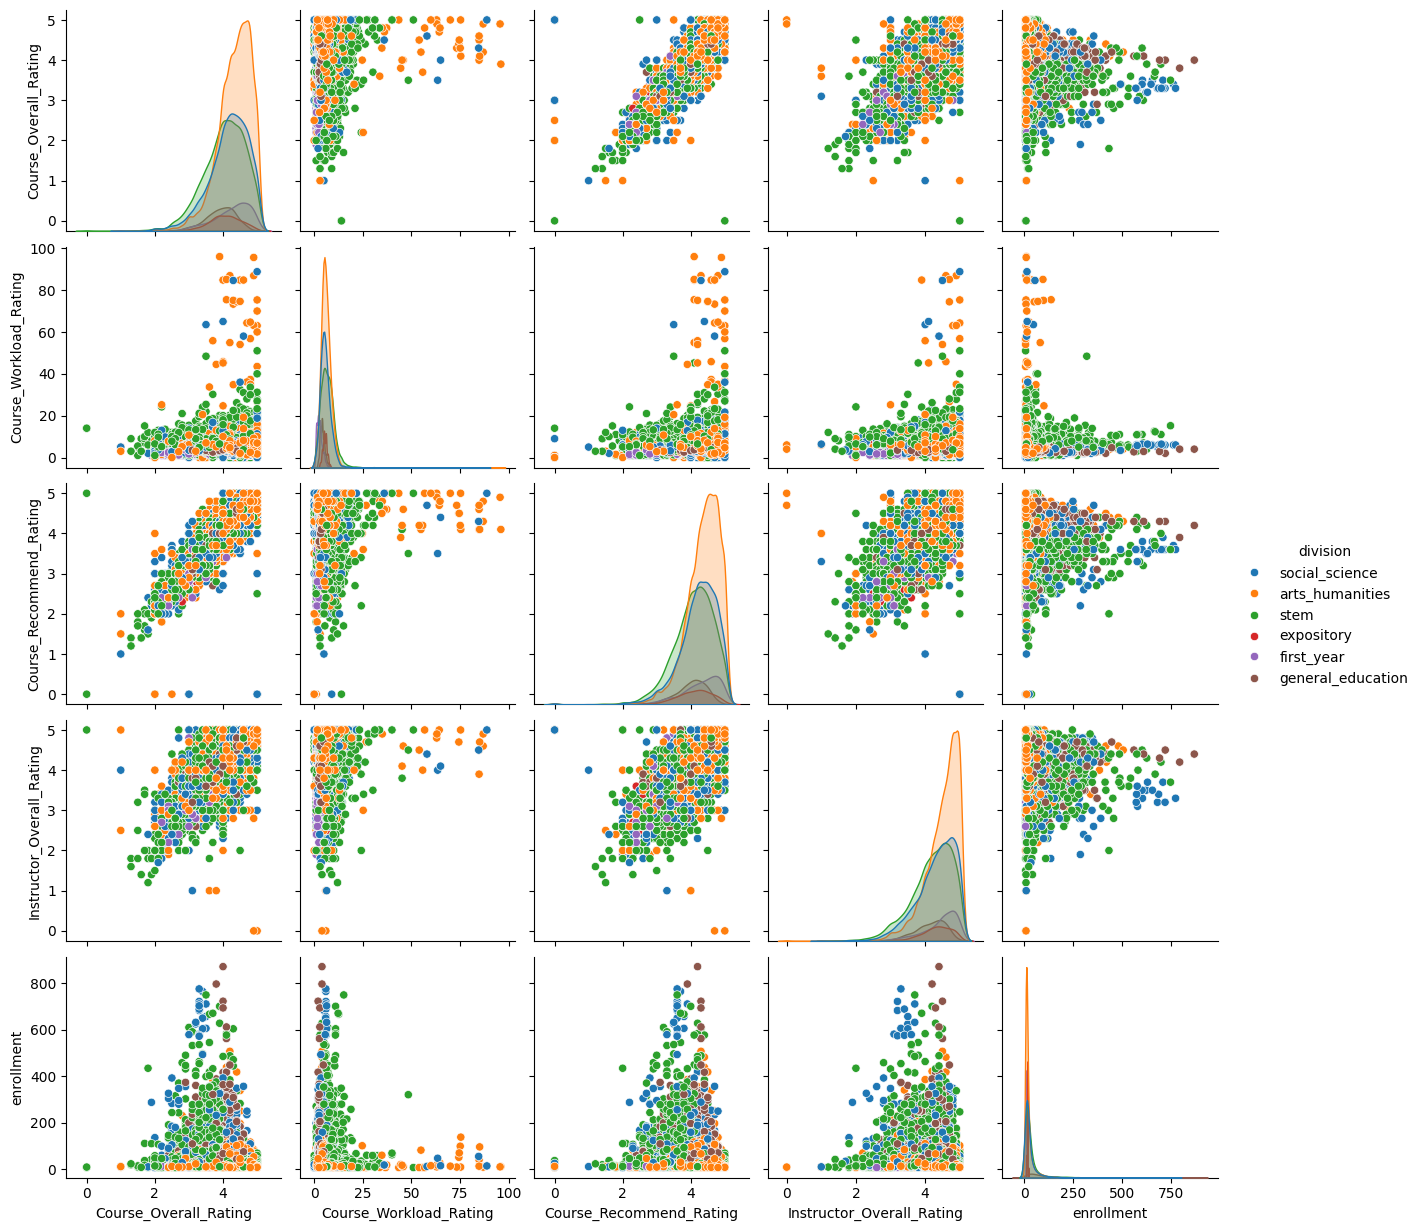

In [56]:
df_copy_drop5 = df_copy_drop5.reset_index(drop=True)

# Select only the columns you're interested in
columns = ['Course_Overall_Rating', 'Course_Workload_Rating', 'Course_Recommend_Rating', 'Instructor_Overall_Rating', 'enrollment', 'division']

# Create a pairplot using Seaborn
sns.pairplot(df_copy_drop5[columns], hue = "division")

# Show the plot
plt.show()

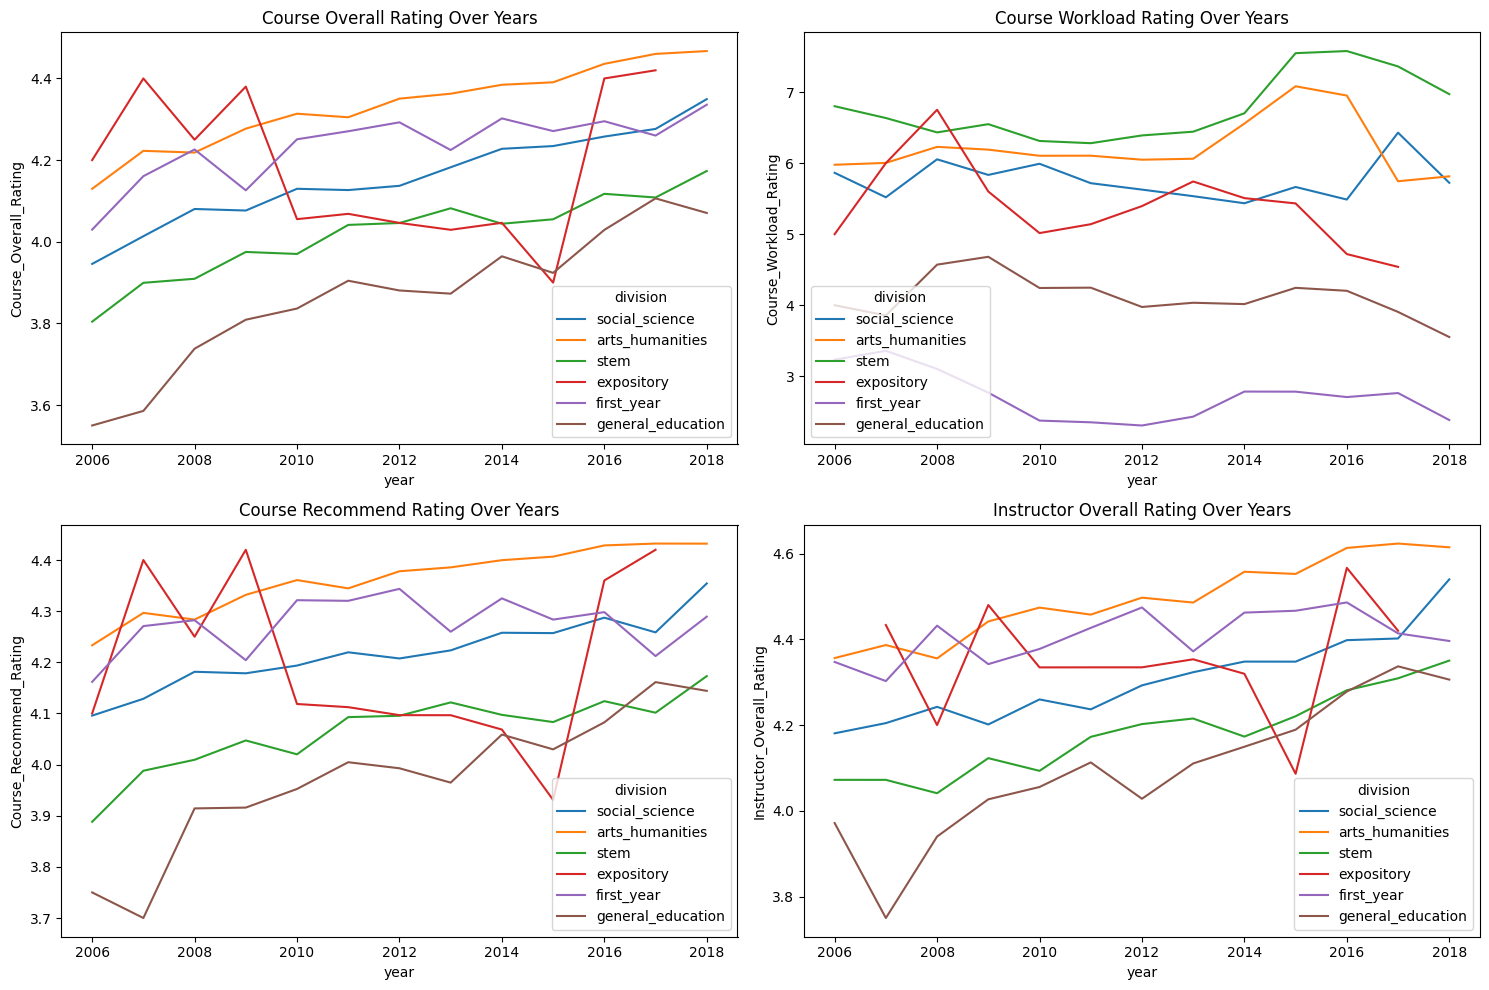

In [57]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Assuming the year column is named 'year'
# Replace 'df' with the name of your DataFrame

# Plot 1: Course_Overall_Rating over years
sns.lineplot(data=df_copy_drop5, x='year', y='Course_Overall_Rating', hue='division', ax=axs[0, 0], errorbar = None)
axs[0, 0].set_title('Course Overall Rating Over Years')

# Plot 2: Course_Workload_Rating over years
sns.lineplot(data=df_copy_drop5, x='year', y='Course_Workload_Rating', hue='division', ax=axs[0, 1], errorbar = None)
axs[0, 1].set_title('Course Workload Rating Over Years')

# Plot 3: Course_Recommend_Rating over years
sns.lineplot(data=df_copy_drop5, x='year', y='Course_Recommend_Rating', hue='division', ax=axs[1, 0], errorbar = None)
axs[1, 0].set_title('Course Recommend Rating Over Years')

# Plot 4: Instructor_Overall_Rating over years
sns.lineplot(data=df_copy_drop5, x='year', y='Instructor_Overall_Rating', hue='division', ax=axs[1, 1], errorbar = None)
axs[1, 1].set_title('Instructor Overall Rating Over Years')

# Adjust the layout
plt.tight_layout()

# Show the plots
plt.show()

## Step 4: Scale

In [58]:
# log enrollment numbers (to not have inf replace 0 with 1e-9)
data_cleaned['enrollment'] = data_cleaned['enrollment'].replace(0, 1e-9)
data_cleaned['log_enrollment'] = np.log(data_cleaned['enrollment'])

# normalize workload hours
std_scaler = StandardScaler()
data_cleaned['norm_Course_Workload_Rating'] = std_scaler.fit_transform(data_cleaned[['Course_Workload_Rating']])

In [59]:
# Remove infinite values
data_cleaned.replace([np.inf, -np.inf], np.nan, inplace=True)

# Step 5: Begin Imputing

In [70]:
# Identify the data types of the remaining columns
column_data_types = data_cleaned.dtypes

# Separate columns by data type for potential different imputation methods
categorical_columns = column_data_types[column_data_types == 'object'].index.tolist()
numerical_columns = column_data_types[column_data_types != 'object'].index.tolist()

In [71]:
# Impute missing values for numerical columns with median
num_imputer = SimpleImputer(strategy='median')  
data_cleaned[numerical_columns] = num_imputer.fit_transform(data_cleaned[numerical_columns])

# Impute missing values for categorical columns with mode
cat_imputer = SimpleImputer(strategy='most_frequent')
data_cleaned[categorical_columns] = cat_imputer.fit_transform(data_cleaned[categorical_columns])

# Step 6: Train-test split

In [73]:
# Convert the 'year' column back to integers (after imputation it was converted to float)
data_cleaned['year'] = data_cleaned['year'].astype('int64')

# Initialize dictionaries to hold the training, validation, and test sets
training_sets = {}
validation_sets = {}
test_sets = {}

# Iterate over the years to create the sets
for start_year in range(2006, 2016):  # last training set starts in 2015
    end_year = start_year + 2  # end year of the training set
    val_year_begin = end_year + 1  # validation year
    val_year_end = end_year + 2  # test year

    # Assign the traininging set
    training_sets[f"{start_year}-{end_year}"] = data_cleaned[data_cleaned['year'].between(start_year, end_year)]

    # Shuffle the dataset for validation and test sets
    data_shuffled = data_cleaned[(data_cleaned['year'] == val_year_begin) | (data_cleaned['year'] == val_year_end)].sample(frac=1, random_state=42).reset_index(drop=True)

    # Split the dataset into training (70%) and a temporary set (30%)
    validation_sets[f"{val_year_begin}-{val_year_end}"], test_sets[f"{val_year_begin}-{val_year_end}"] = train_test_split(data_shuffled, test_size=0.5, stratify=data_shuffled['year'], random_state=42)

validation_size = len(validation_sets['2009-2010'])
test_size = len(test_sets['2009-2010'])

In [87]:
X_trains = {}
y_trains = {}
X_valids = {}
y_valids = {}

for key, train_data in training_sets.items():
    X_trains[key] = train_data.drop('log_enrollment', axis=1)  # Features
    X_trains[key] = pd.get_dummies(X_trains[key], columns=['division'])
    y_trains[key] = train_data['log_enrollment']  # Target variable

for key, valid_data in validation_sets.items():
    X_valids[key] = valid_data.drop('log_enrollment', axis=1)  # Features
    X_valids[key] = pd.get_dummies(X_valids[key], columns=['division'])
    y_valids[key] = valid_data['log_enrollment']  # Target variable

# Step 7: Create the model

In [97]:
def evaluate_models(X_trains, y_trains, X_valids, y_valids, models):
    results = {}
    num_models = len(models)
    fig, ax = plt.subplots(num_models, 1, figsize=(10, 5 * num_models))
    if num_models == 1:
        ax = [ax]  # Ensure ax is iterable even for a single model

    for i, (model_name, model) in enumerate(models.items()):
        train_mses = []
        valid_mses = []
        
        # Ensure that we have the same order of keys for both training and validation sets
        train_keys = list(X_trains.keys())
        valid_keys = list(X_valids.keys())

        for j, key in enumerate(train_keys):
            corresponding_valid_key = valid_keys[j]

            # Training set preparation
            X_train, y_train = X_trains[key].copy(), y_trains[key].copy()
            X_train = X_train.select_dtypes(include=['number'])

            # Validation set preparation
            X_valid, y_valid = X_valids[corresponding_valid_key].copy(), y_valids[corresponding_valid_key].copy()
            X_valid = X_valid.select_dtypes(include=['number'])

            # Model training and prediction
            model.fit(X_train, y_train)
            y_train_pred = model.predict(X_train)
            y_valid_pred = model.predict(X_valid)

            # Compute metrics
            train_mse = mean_squared_error(y_train, y_train_pred)
            valid_mse = mean_squared_error(y_valid, y_valid_pred)
            train_mses.append(train_mse)
            valid_mses.append(valid_mse)

            # Additional metrics
            train_r2 = r2_score(y_train, y_train_pred)
            valid_r2 = r2_score(y_valid, y_valid_pred)
            train_mae = mean_absolute_error(y_train, y_train_pred)
            valid_mae = mean_absolute_error(y_valid, y_valid_pred)

            results.setdefault(model_name, []).append({
                'train_key': key,
                'valid_key': corresponding_valid_key,
                'train_mse': train_mse,
                'valid_mse': valid_mse,
                'train_r2': train_r2,
                'valid_r2': valid_r2,
                'train_mae': train_mae,
                'valid_mae': valid_mae
            })

        # Plotting
        ax[i].plot(train_keys, train_mses, label='Train MSE')
        ax[i].plot(train_keys, valid_mses, label='Valid MSE')
        ax[i].set_title(model_name)
        ax[i].set_xlabel('Dataset Index')
        ax[i].set_ylabel('MSE')
        ax[i].legend()

    plt.tight_layout()
    plt.show()

    return results

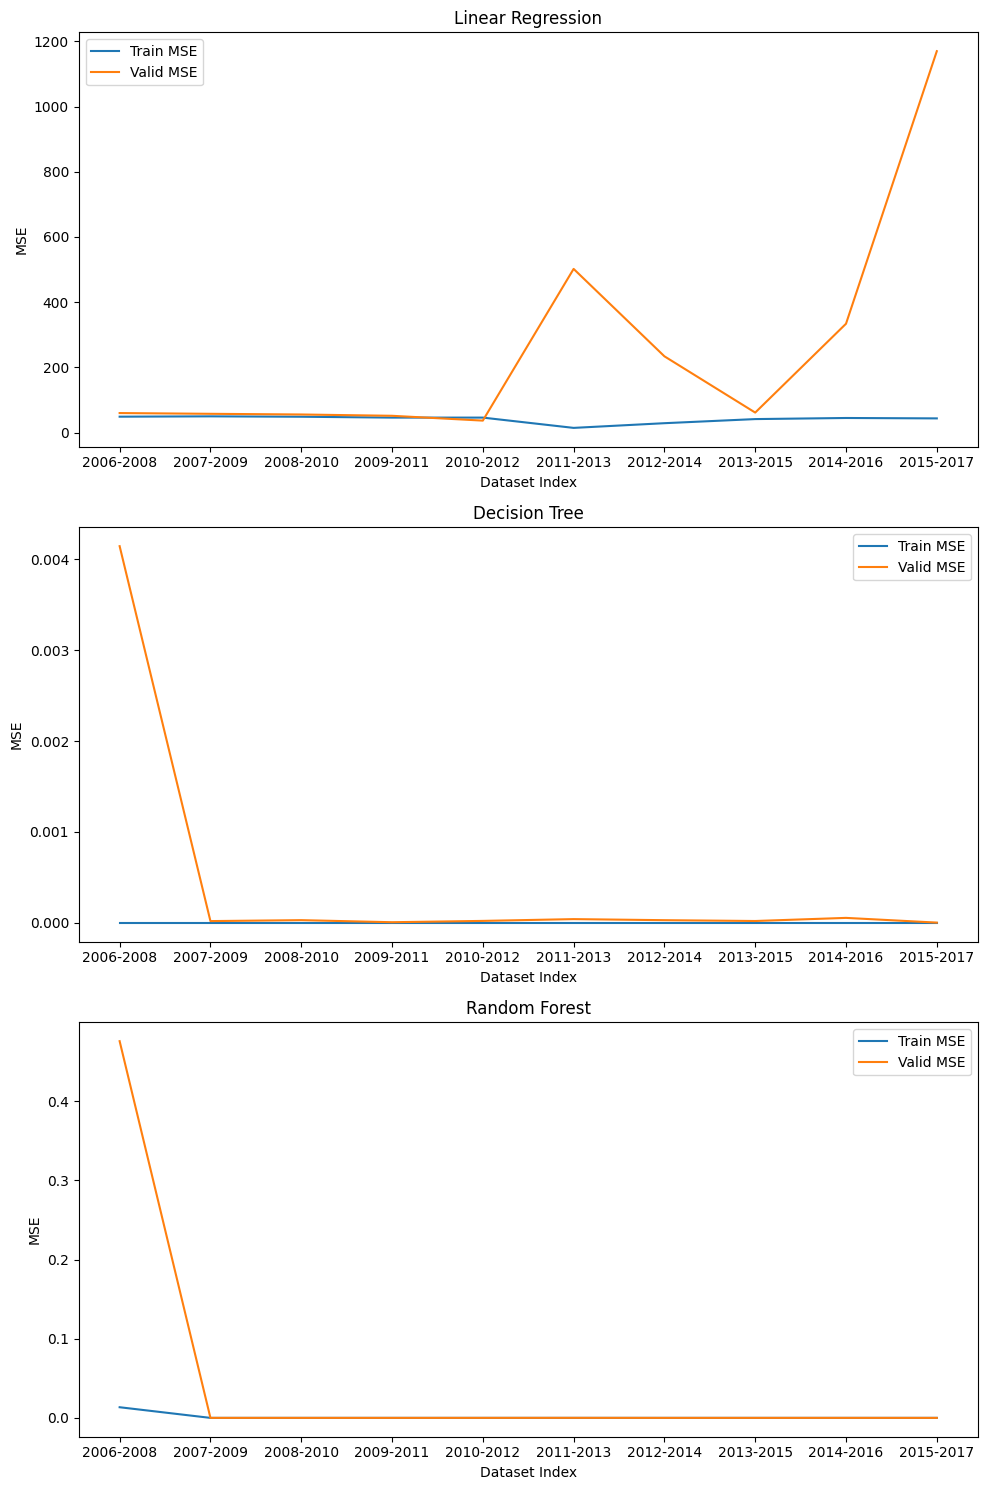

In [98]:
# Define the models to test
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor()
}

# Evaluate all models
model_performance = evaluate_models(X_trains, y_trains, X_valids, y_valids, models)

### Zooming in on the linear regression model

In [105]:
def evaluate_polynomial_models(X_trains, y_trains, X_valids, y_valids, max_degree):
    results = {}
    train_mses = []
    valid_mses = []
    degrees = range(1, max_degree + 1)

    # Ensure that we have the same order of keys for both training and validation sets
    train_keys = list(X_trains.keys())
    valid_keys = list(X_valids.keys())

    for degree in degrees:
        current_train_mses = []
        current_valid_mses = []

        for j, key in enumerate(train_keys):
            corresponding_valid_key = valid_keys[j]

            # Polynomial feature transformation
            poly = PolynomialFeatures(degree)
            X_train_poly = poly.fit_transform(X_trains[key].select_dtypes(include=['number']))
            X_valid_poly = poly.transform(X_valids[corresponding_valid_key].select_dtypes(include=['number']))

            # Model training and prediction
            model = LinearRegression()
            model.fit(X_train_poly, y_trains[key])
            y_train_pred = model.predict(X_train_poly)
            y_valid_pred = model.predict(X_valid_poly)

            # Compute MSE
            train_mse = mean_squared_error(y_trains[key], y_train_pred)
            valid_mse = mean_squared_error(y_valids[corresponding_valid_key], y_valid_pred)
            current_train_mses.append(train_mse)
            current_valid_mses.append(valid_mse)

        avg_train_mse = np.mean(current_train_mses)
        avg_valid_mse = np.mean(current_valid_mses)
        train_mses.append(avg_train_mse)
        valid_mses.append(avg_valid_mse)

        results[degree] = {'avg_train_mse': avg_train_mse, 'avg_valid_mse': avg_valid_mse}
    # Identify best degree
    best_degree = degrees[np.argmin(valid_mses)]
    print(f"Best polynomial degree: {best_degree} with Validation MSE: {results[best_degree]['avg_valid_mse']}")

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(degrees, train_mses, label='Average Train MSE')
    plt.plot(degrees, valid_mses, label='Average Valid MSE')
    plt.xlabel('Polynomial Degree')
    plt.ylabel('MSE')
    plt.title('Polynomial Degree vs MSE')
    plt.legend()
    plt.show()

    return results, best_degree

In [106]:
# Set the maximum degree of polynomial features you want to test
max_degree = 3

# Call the function with your data
results, best_degree = evaluate_polynomial_models(X_trains, y_trains, X_valids, y_valids, max_degree)
print(results)
print(best_degree)

KeyboardInterrupt: 

### Zooming in on the Decission tree model

In [ ]:
def optimize_decision_tree(X_trains, y_trains, X_valids, y_valids, max_depth_range):
    best_mse = float('inf')
    best_params = None
    results = []
    mses = []

    train_keys = list(X_trains.keys())
    valid_keys = list(X_valids.keys())

    for depth in max_depth_range:
        current_mses = []

        for j, key in enumerate(train_keys):
            corresponding_valid_key = valid_keys[j]

            # Model training and prediction
            model = DecisionTreeRegressor(max_depth=depth)
            model.fit(X_trains[key].select_dtypes(include=['number']), y_trains[key])
            y_valid_pred = model.predict(X_valids[corresponding_valid_key].select_dtypes(include=['number']))

            # Compute MSE
            mse = mean_squared_error(y_valids[corresponding_valid_key], y_valid_pred)
            current_mses.append(mse)

        avg_mse = np.mean(current_mses)
        mses.append(avg_mse)
        results.append((depth, avg_mse))

        if avg_mse < best_mse:
            best_mse = avg_mse
            best_params = depth

    # Plotting the MSEs
    plt.figure(figsize=(10, 6))
    plt.plot(max_depth_range, mses, marker='o')
    plt.xlabel('Max Depth')
    plt.ylabel('Average Validation MSE')
    plt.title('Decision Tree - Max Depth vs. Validation MSE')
    plt.grid(True)
    plt.show()

    print(f"Best max_depth: {best_params} with Validation MSE: {best_mse}")
    return results, best_params

In [ ]:
max_depth_range = range(1, 7) 
dt_results, dt_best_params = optimize_decision_tree(X_trains, y_trains, X_valids, y_valids, max_depth_range)

### Zooming in on the Random forest model

In [ ]:
def optimize_random_forest(X_trains, y_trains, X_valids, y_valids, n_estimators_range, max_depth_range):
    best_mse = float('inf')
    best_params = None
    results = []
    plot_data = {'n_estimators': [], 'max_depth': [], 'mse': []}

    train_keys = list(X_trains.keys())
    valid_keys = list(X_valids.keys())

    for n_estimators in n_estimators_range:
        for max_depth in max_depth_range:
            current_mses = []

            for j, key in enumerate(train_keys):
                corresponding_valid_key = valid_keys[j]

                # Model training and prediction
                model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
                model.fit(X_trains[key].select_dtypes(include=['number']), y_trains[key])
                y_valid_pred = model.predict(X_valids[corresponding_valid_key].select_dtypes(include=['number']))

                # Compute MSE
                mse = mean_squared_error(y_valids[corresponding_valid_key], y_valid_pred)
                current_mses.append(mse)

            avg_mse = np.mean(current_mses)
            results.append(((n_estimators, max_depth), avg_mse))
            plot_data['n_estimators'].append(n_estimators)
            plot_data['max_depth'].append(max_depth)
            plot_data['mse'].append(avg_mse)

            if avg_mse < best_mse:
                best_mse = avg_mse
                best_params = (n_estimators, max_depth)

    # Plotting the MSEs
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(plot_data['n_estimators'], plot_data['max_depth'], plot_data['mse'], color='b')
    ax.set_xlabel('Number of Estimators')
    ax.set_ylabel('Max Depth')
    ax.set_zlabel('Average Validation MSE')
    ax.set_title('Random Forest Hyperparameter Tuning')
    plt.show()

    print(f"Best parameters: n_estimators={best_params[0]}, max_depth={best_params[1]} with Validation MSE: {best_mse}")
    return results, best_params

In [ ]:
n_estimators_range = [5, 10, 50, 100]  
max_depth_range_rf = range(1, 7) 
rf_results, rf_best_params = optimize_random_forest(X_trains, y_trains, X_valids, y_valids, n_estimators_range, max_depth_range_rf) 